#Dueling Deep Q-Network
---

Dueling Q network architecture was proposed in the [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581) paper. The general idea is to calculate state action values using state values $V(s)$ and advantages $A(s, a) = Q(s, a) - V(s)$. It is being done by bulding a network architecture with parallel layers for calculating $V(s)$ and  $A(s, a)$ as presented in the image (image from the abovementioned paper).

<img src="img/DuelingQNetwork.jpg" alt="Dueling Q Network" style="width: 640px;">

The only issue is how to ensure that $V(s)$ will produce a reasonable estimate for state values. We are doing it, by assuming, that the mean advantage value should always be 0. Thus the final formula:

$$Q(s, a) = V(s) + A(s, a) - \frac{1}{|A|}\sum\limits_{a'}A(s, a')$$

This is all implemented in `DuelingQNetwork` class.

There is one more improvement - to keep it consistent with the paper I clipped the gradients to 10 in order to avoid gradient exploding problem.






In [1]:
# Import packages
import gym
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Device:', device)

Device: cuda:0


In [2]:
env = gym.make(config.ENVIRONMENT)

In [3]:
from rainbow.dueling_agent import Agent

agent = Agent(
    state_size=env.observation_space.shape[0], 
    action_size=env.action_space.n,
    buffer_size = int(1e5),
    batch_size = 64,
    gamma = 0.99,
    lr = 5e-4,
    update_every = 4, # How often to update the network
    device=device,
    # PER parameters
    per_alpha = 0.2,
    per_beta_start = 0.4,
    per_beta_frames = 1e5,
    per_prior_eps = 1e-6, 
    # Dueling parameters
    clip_grad=10,  
    )



In [4]:
def train_agent(n_episodes=config.MAX_EPISODES, 
        max_t=config.MAX_TIMESTEPS, 
        eps_start=config.EPSILON_START, 
        eps_end=config.EPSILON_END, 
        eps_decay=config.EPSILON_DECAY,
        expected_reward = config.EXPECTED_REWARD,
        update_target_every = 4
):
    """Deep Q-Learning.
    Args:
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for 
            epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): decay factor (per episode) 
            for decreasing epsilon
        expected_reward (float): finish when the average score
            is greater than this value
        upate_target_every (int): how often should the target 
            network be updated. Default: 1 (per every episode) 
    Returns:
        scores (list): list of scores from each episode
    """
    scores = []                        
    scores_window = deque(maxlen=100)  
    eps = eps_start                    
    for episode in range(1, n_episodes+1):
        state, info = env.reset()
        score = 0
        for t in range(max_t):
            
            action = agent.act(state, eps)
            next_state, reward, done, truncated, info = env.step(action)
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       
        scores.append(score)
                
        eps = max(eps_end, eps_decay*eps) 
        
        if episode % update_target_every == 0:
            agent.target_hard_update()
        
        mean_score = np.mean(scores_window)
        print(f'\rEpisode {episode}\tAverage Score: {mean_score:.2f}', end="")
        if episode % 100 == 0:
            print(f'\rEpisode {episode}\tAverage Score: {mean_score:.2f}')
            agent.save('checkpoint.pth')
        if mean_score >= expected_reward:
            print(f'\nDone in {episode:d} episodes!\tAverage Score: {mean_score:.2f}')
            agent.save('checkpoint.pth')
            break
    return scores

### Train the agent


Episode 100	Average Score: 17.99
Episode 200	Average Score: 98.73
Episode 280	Average Score: 230.13
Done in 280 episodes!	Average Score: 230.13


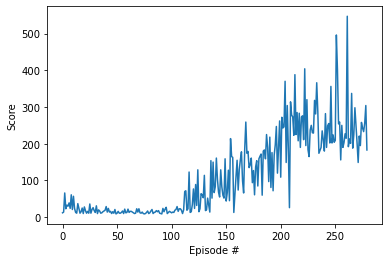

In [5]:
scores = train_agent()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()